In [1]:
import pandas as pd

In [2]:
df = pd.read_csv ("Supermart Grocery Sales.csv")
df.head()

,Order ID,Customer Name,Category,Sub Category,City,Order Date,Region,Sales,Discount,Profit,State
0,OD1,Harish,Oil & Masala,Masalas,Vellore,11-08-2017,North,1254,0.12,401.28,Tamil Nadu
1,OD2,Sudha,Beverages,Health Drinks,Krishnagiri,11-08-2017,South,749,0.18,149.80,Tamil Nadu
2,OD3,Hussain,Food Grains,Atta & Flour,Perambalur,06-12-2017,West,2360,0.21,165.20,Tamil Nadu
3,OD4,Jackson,Fruits & Veggies,Fresh Vegetables,Dharmapuri,10-11-2016,South,896,0.25,89.60,Tamil Nadu
4,OD5,Ridhesh,Food Grains,Organic Staples,Ooty,10-11-2016,South,2355,0.26,918.45,Tamil Nadu


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9994 non-null   object 
 1   Customer Name  9994 non-null   object 
 2   Category       9994 non-null   object 
 3   Sub Category   9994 non-null   object 
 4   City           9994 non-null   object 
 5   Order Date     9994 non-null   object 
 6   Region         9994 non-null   object 
 7   Sales          9994 non-null   int64  
 8   Discount       9994 non-null   float64
 9   Profit         9994 non-null   float64
 10  State          9994 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 859.0+ KB


In [7]:
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')


missing_dates = df['Order Date'].isnull().sum()

missing_dates, df.head()

(5952,
   Order ID Customer Name          Category      Sub Category         City  \
 0      OD1        Harish      Oil & Masala           Masalas      Vellore   
 1      OD2         Sudha         Beverages     Health Drinks  Krishnagiri   
 2      OD3       Hussain       Food Grains      Atta & Flour   Perambalur   
 3      OD4       Jackson  Fruits & Veggies  Fresh Vegetables   Dharmapuri   
 4      OD5       Ridhesh       Food Grains   Organic Staples         Ooty   
 
   Order Date Region  Sales  Discount  Profit       State  
 0 2017-11-08  North   1254      0.12  401.28  Tamil Nadu  
 1 2017-11-08  South    749      0.18  149.80  Tamil Nadu  
 2 2017-06-12   West   2360      0.21  165.20  Tamil Nadu  
 3 2016-10-11  South    896      0.25   89.60  Tamil Nadu  
 4 2016-10-11  South   2355      0.26  918.45  Tamil Nadu  )

### exploratory data analysis (EDA) to identify
### Sales trends over time,Seasonal demand patterns,Impact of discounts on sales and profits,Category-wise and region-wise demand.

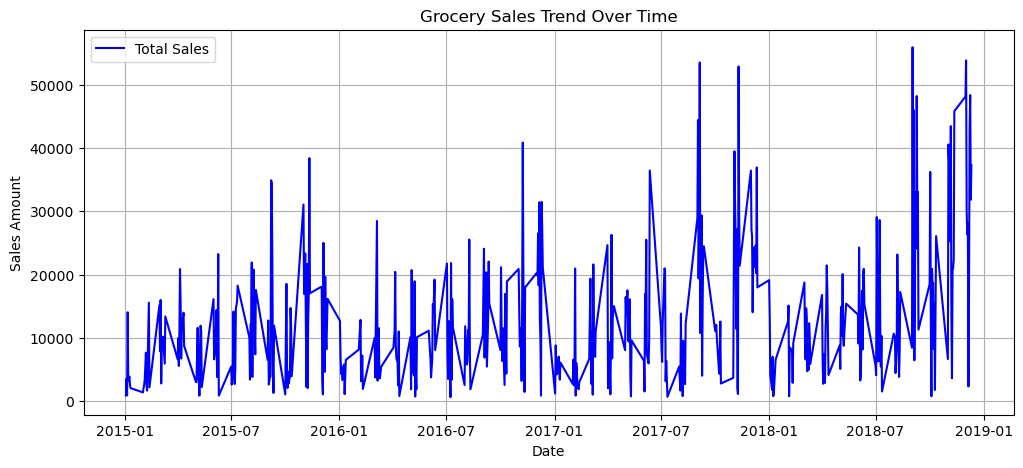

In [8]:
import matplotlib.pyplot as plt

# Aggregate sales by date
df_sales_trend = df.groupby('Order Date')['Sales'].sum()

# Plot sales trend over time
plt.figure(figsize=(12, 5))
plt.plot(df_sales_trend.index, df_sales_trend.values, label='Total Sales', color='b')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.title('Grocery Sales Trend Over Time')
plt.legend()
plt.grid(True)
plt.show()

### monthly sales trends

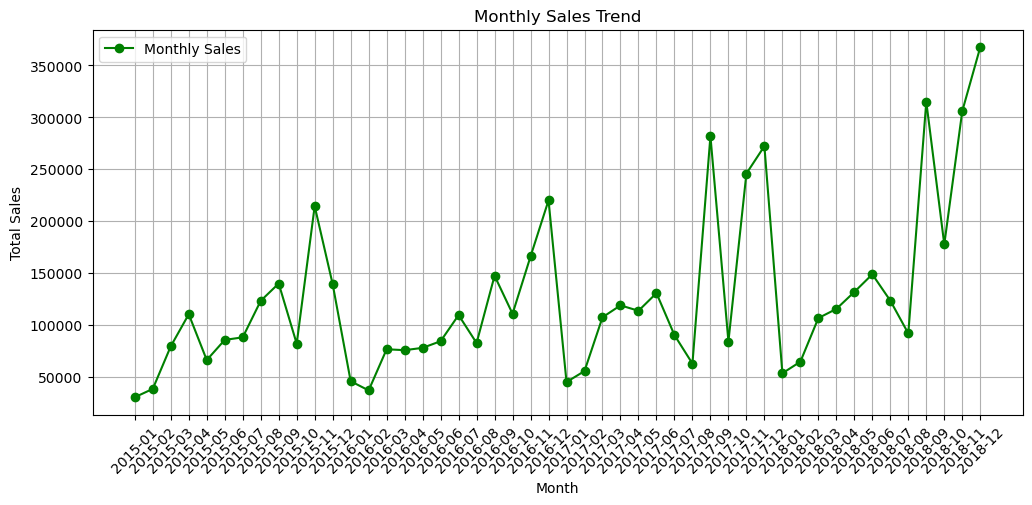

In [10]:
# Extract year and month for trend analysis
df['YearMonth'] = df['Order Date'].dt.to_period('M')

# Aggregate sales by month
monthly_sales = df.groupby('YearMonth')['Sales'].sum()

# Plot monthly sales trend
plt.figure(figsize=(12, 5))
plt.plot(monthly_sales.index.astype(str), monthly_sales.values, marker='o', linestyle='-', color='g', label='Monthly Sales')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Trend')
plt.legend()
plt.grid(True)
plt.show()


### Category-wise sales distribution
### Impact of discounts on sales and profits

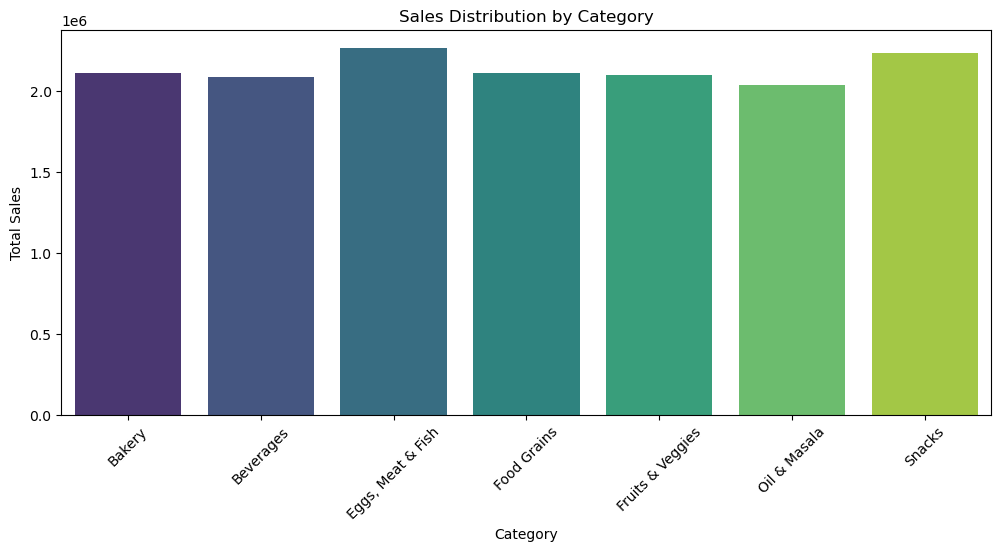

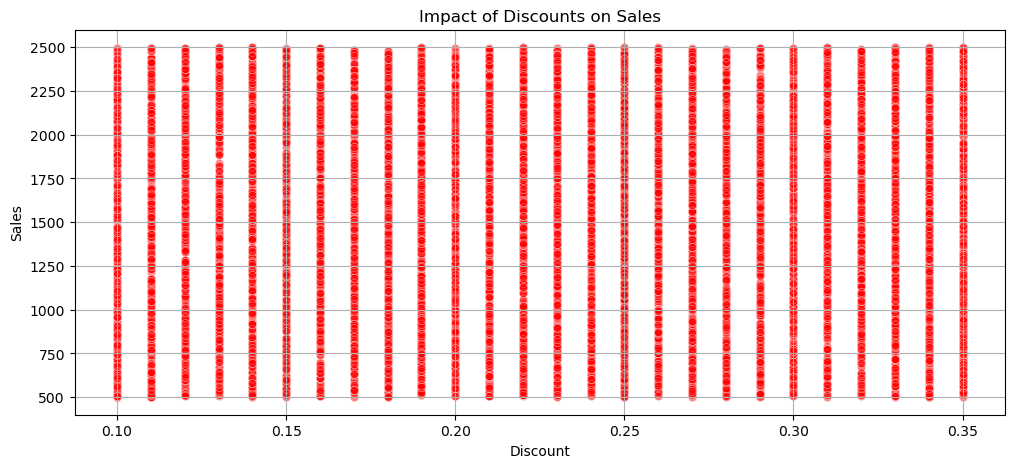

In [11]:
import seaborn as sns

# Category-wise sales distribution
plt.figure(figsize=(12, 5))
sns.barplot(x=df.groupby('Category')['Sales'].sum().index, y=df.groupby('Category')['Sales'].sum().values, palette='viridis')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.title('Sales Distribution by Category')
plt.xticks(rotation=45)
plt.show()

# Discount vs. Sales relationship
plt.figure(figsize=(12, 5))
sns.scatterplot(x=df['Discount'], y=df['Sales'], alpha=0.5, color='r')
plt.xlabel('Discount')
plt.ylabel('Sales')
plt.title('Impact of Discounts on Sales')
plt.grid(True)
plt.show()


### Feature Engineering

In [12]:
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['DayOfWeek'] = df['Order Date'].dt.dayofweek

# Aggregate sales at a daily level for modeling
df_model = df.groupby('Order Date').agg({'Sales': 'sum', 'Discount': 'mean'}).reset_index()

# Add lag features (previous days' sales)
df_model['Sales_Lag_1'] = df_model['Sales'].shift(1)
df_model['Sales_Lag_7'] = df_model['Sales'].shift(7)
df_model['Sales_Lag_30'] = df_model['Sales'].shift(30)

# Drop initial rows with NaN due to lagging
df_model.dropna(inplace=True)

# Display the prepared dataset
df_model.head()


,Order Date,Sales,Discount,Sales_Lag_1,Sales_Lag_7,Sales_Lag_30
30,2015-04-06,15610,0.236923,20860.0,5892.0,864.0
31,2015-04-07,6693,0.240000,15610.0,13357.0,3490.0
32,2015-04-08,11536,0.221429,6693.0,6580.0,878.0
33,2015-04-11,13952,0.246667,11536.0,9940.0,14026.0
34,2015-04-12,8703,0.251667,13952.0,5525.0,3216.0


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Define features and target variable
features = ['Discount', 'Sales_Lag_1', 'Sales_Lag_7', 'Sales_Lag_30']
target = 'Sales'

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_model[features], df_model[target], test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2


(7468.142087912089, 0.029571764876571982)

### Model Performance:
Mean Absolute Error (MAE): ~5513 (indicating the average prediction error)
R² Score: ~0.23 (suggesting room for improvement)